# Homework 2: Binary Classification with Artificial Neural Networks and Support Vector Machines

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035

# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [1]:
import logging
import logging.config
import yaml
import textwrap


class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


HOMEWORK_DIR = '/Users/ondergormez/Repos/BLM5110_Machine_Learning/02-Homeworks/Homework2/'
LOGGER_CONFIG_FILE = HOMEWORK_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.INFO)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[INFO] [2024-12-15T17:23:14.827Z] Logging is configured successfully.


# 1. Veri Kümesi Oluşturma

## 1. - a. make_moons Fonksiyonunu Kullanımı

Önce scikit-learn’de bulunan make_moons fonksiyonunu (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) kullanarak 400 örnekten oluşan iki sınıflı bir veri kümesi oluşturunuz.

In [2]:
import pandas as pd
from sklearn.datasets import make_moons

# Generate a synthetic dataset
# Not: noise vermezsek data tamamen yarım ay şeklinde olan 2 sınıftan oluşuyor.
X, y = make_moons(n_samples=400, noise=0.1, random_state=648)
logger.info("X.shape: %s, y.shape: %s", X.shape, y.shape)

# Convert the dataset to a pandas DataFrame
dataset_df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
dataset_df['Output'] = y

num_distinct_values = dataset_df['Output'].nunique()
logger.info("Number of distinct values in the 'Output' column: %s", num_distinct_values)

distinct_values = dataset_df['Output'].unique()
logger.info("Distinct values in the 'Output' column: %s", distinct_values)

# Set 0 and 1 to class 1 and class 2 for better understanding
dataset_df['Output'] = dataset_df['Output'].map({0: 'Class 1', 1: 'Class 2'})

dataset_df.head()

[INFO] [2024-12-15T17:23:15.431Z] X.shape: (400, 2), y.shape: (400,)
[INFO] [2024-12-15T17:23:15.432Z] Number of distinct values in the 'Output' column: 2
[INFO] [2024-12-15T17:23:15.432Z] Distinct values in the 'Output' column: [0 1]


,Feature 1,Feature 2,Output
0,0.640754,0.733369,Class 1
1,2.182398,0.578725,Class 2
2,1.174869,-0.493542,Class 2
3,-0.751207,0.591934,Class 1
4,0.226786,0.967683,Class 1


## 1. - b. Oluşturulan Veri Kümesinin Görselleştirilmesi

Oluşturduğunuz veri kümesindeki iki sınıftaki örnekleri iki farklı renk ile göstererek çizdiriniz.

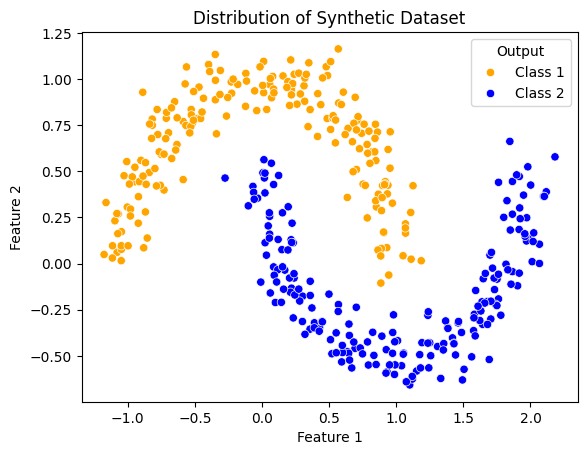

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors for each class
colors = {'Class 1': 'orange', 'Class 2': 'blue'}

sns.scatterplot(data=dataset_df, x='Feature 1', y='Feature 2', hue='Output', palette=colors)
plt.title("Distribution of Synthetic Dataset")
plt.show()

## 1. - c. Train, Validation ve Test Set lerinin Oluşturulması

Veri kümesinden örnekleri rasgele seçerek %60’ını eğitim, %20’sini doğrulama, %20’sini test
için ayırınız.

İlk önce datayı ayırmadan önceki dağılımına bakalım.

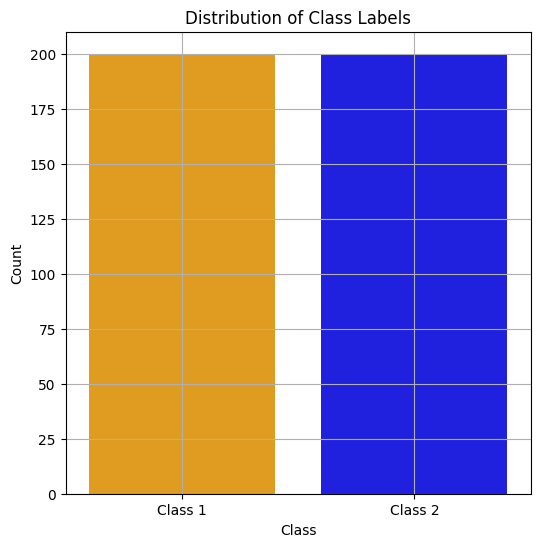

In [4]:
# Plot the distribution of the data as a bar plot
plt.figure(figsize=(6, 6))
sns.countplot(data=dataset_df, x='Output', hue='Output', palette=colors)
plt.title('Distribution of Class Labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# %80 e, %20 test olarak ayrılıyor
# stratify=y: y'yi yani class label ları dengeli bir şekilde bölmek için kullanılır.
# Veri seti bölünmeden önceki sınıf dağılımını korur. Bu veri seti için %50-%50 olacak şekilde korunur.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=68, stratify=y)

# Temp veri setinin %75'i train %25'i validation set olarak ayrılır.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=325, stratify=y_temp)

logger.info(f"Train set size: {len(X_train)}")
logger.info(f"Validation set size: {len(X_val)}")
logger.info(f"Test set size: {len(X_test)}")

[INFO] [2024-12-15T17:23:15.929Z] Train set size: 240
[INFO] [2024-12-15T17:23:15.930Z] Validation set size: 80
[INFO] [2024-12-15T17:23:15.930Z] Test set size: 80


Ayrılan sınıflar için bar plot çizdirelim.

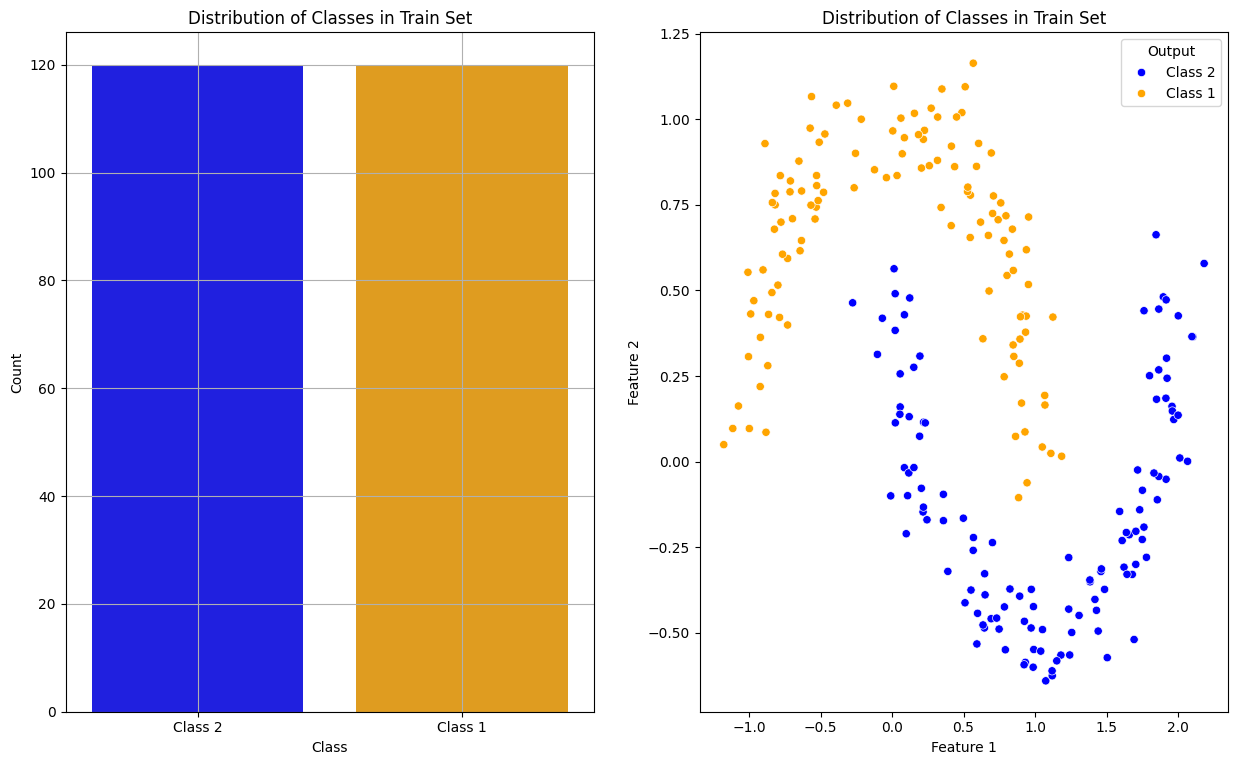

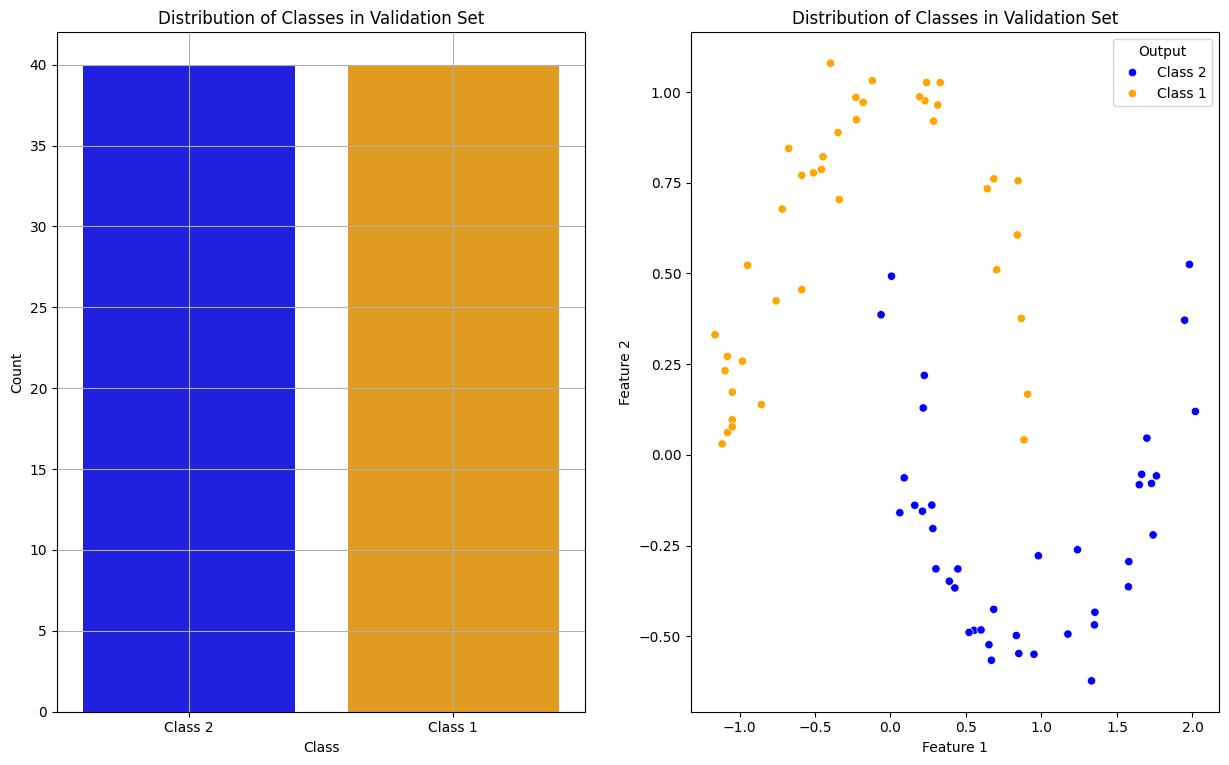

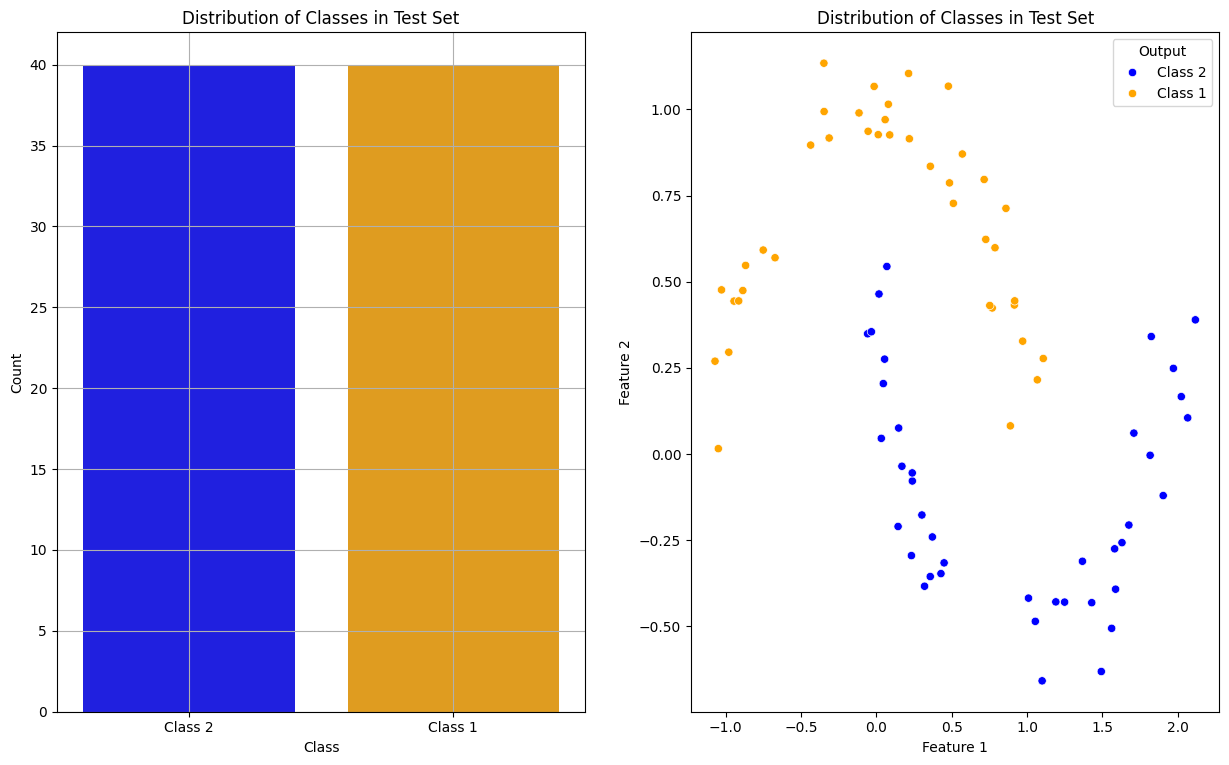

<Figure size 640x480 with 0 Axes>

In [6]:
# Convert the train, validation, and test sets to pandas DataFrames
train_dataset_df = pd.DataFrame(X_train, columns=['Feature 1', 'Feature 2'])
train_dataset_df['Output'] = y_train
# Set 0 and 1 to class 1 and class 2 for better understanding
train_dataset_df['Output'] = train_dataset_df['Output'].map({0: 'Class 1', 1: 'Class 2'})

val_dataset_df = pd.DataFrame(X_val, columns=['Feature 1', 'Feature 2'])
val_dataset_df['Output'] = y_val
# Set 0 and 1 to class 1 and class 2 for better understanding
val_dataset_df['Output'] = val_dataset_df['Output'].map({0: 'Class 1', 1: 'Class 2'})

test_dataset_df = pd.DataFrame(X_test, columns=['Feature 1', 'Feature 2'])
test_dataset_df['Output'] = y_test
# Set 0 and 1 to class 1 and class 2 for better understanding
test_dataset_df['Output'] = test_dataset_df['Output'].map({0: 'Class 1', 1: 'Class 2'})

# Plot the distribution of the data as count plots and also as scatter plots

# Train set
plt.figure(figsize=(15, 30))
plt.subplot(3, 2, 1)
sns.countplot(data=train_dataset_df, x='Output', hue='Output', palette=colors)
plt.title('Distribution of Classes in Train Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(3, 2, 2)
sns.scatterplot(data=train_dataset_df, x='Feature 1', y='Feature 2', hue='Output', palette=colors)
plt.title('Distribution of Classes in Train Set')
plt.show()

# Validation set
plt.figure(figsize=(15, 30))
plt.subplot(3, 2, 3)
sns.countplot(data=val_dataset_df, x='Output', hue='Output', palette=colors)
plt.title('Distribution of Classes in Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(3, 2, 4)
sns.scatterplot(data=val_dataset_df, x='Feature 1', y='Feature 2', hue='Output', palette=colors)
plt.title('Distribution of Classes in Validation Set')
plt.show()

# Test set
plt.figure(figsize=(15, 30))
plt.subplot(3, 2, 5)
sns.countplot(data=test_dataset_df, x='Output', hue='Output', palette=colors)
plt.title('Distribution of Classes in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(3, 2, 6)
sns.scatterplot(data=test_dataset_df, x='Feature 1', y='Feature 2', hue='Output', palette=colors)
plt.title('Distribution of Classes in Test Set')
plt.show()

plt.tight_layout()
plt.show()

# 2. Yapay Nöron Ağı / Artificial Neural Network (ANN)

Yapay Nöron Ağı öğrenme modeli için aşağıdaki işlemleri yapınız.

* Yapay Nöron Ağı modelini oluşturmak için Keras kütüphanesini kullanacağız.
* Keras kütüphanesi içerisinde **Sequential modelini** kullanarak bir model oluşturacağız.
* Sequential modeli içerisinde **Dense katmanlarını** kullanarak nöronları oluşturacağız.
* Hidden layer ları tanımlamadan önce input layer ı tanımlamamız gerekiyor. 
  * Bizim sınıfımızda 2 tane feature olduğu için input layer ımızın girişinin dimension ı 2 olacak.
  * Gizli katmanlarda ise 10 tane nöron olduğu için giriş katmanının çıkışında her bir feature nöronlar ile 10 tane bağlantı kuracak. Her nöronun çıkışında da 10 tane output üretilecek. Bu nedenle toplam 30 tane bağlantı olacak.


Raporda kullanılacak olan verbosity seviyesi aşağıdaki gibi ayarlanmıştır.

In [7]:
# 0: no verbose, 1: verbose
verbosity_level = 0

* Aşağıdaki kod parçasında input layer ı tanımlıyoruz.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=2, activation='sigmoid'))
model.summary()

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)


# 2. - a. Loss Hesabı

Loss fonksiyonu olarak Binary Cross Entropy kullanınız.
* Bunu modeli compile ederken aşağıdaki kod parçası ile yapabiliriz.

In [9]:
# model.compile(optimizer=SGD(), loss=BinaryCrossentropy(), metrics=['accuracy'])

## 2. - b. Sigmoid Aktivasyon Fonksiyonu

Aktivasyon fonksiyonu olarak sigmoid kullanınız.
* Bunu modele katmanları (layer) eklerken aşağıdaki kod parçası ile yapabiliriz.


In [10]:
# model.add(Dense(10, activation='sigmoid'))

## 2. - c. Gizli Katmanlar - Hidden Layers

* Gizli katmanlar ne giriş katmanı ne de çıkış katmanı olan katmanlardır.
* Bunun en basit örneği Multi Layer Perceptron (MLP) yapısıdır.

Sırasıyla 1, 2 ve 3 gizli katmanlı ağlar için aşağıdaki işlemleri yapınız.
* Bunun için model oluşturan bir fonksiyon yazabiliriz.
* Bu fonksiyon parametre olarak gizli katman sayısını alır ve modeli oluşturur.

In [11]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy

def create_model(hidden_layer_count):
    model = Sequential()
    
    # input layer: 2 feature olduğu için input_dim=2
    model.add(Dense(10, input_dim=2, activation='sigmoid', name='input_layer'))
    
    # parametrik olarak ara katmanlar eklenir
    for _ in range(hidden_layer_count):
        hidden_layer_name = f'hidden_layer_{_ + 1}'
        model.add(Dense(10, activation='sigmoid', name=hidden_layer_name))
    
    # output layer: binary classification olduğu için 1 nöron ve sigmoid aktivasyon fonksiyonu kullanılır.
    model.add(Dense(1, activation='sigmoid', name='output_layer'))

    model.compile(optimizer=SGD(), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

### Stochastic Gradient Descent (SGD) vs Batch Gradient Descent vs Mini Batch Gradient Descent

* Stochastic Gradient Descent (SGD): Her bir örnek için ağı günceller.
* Batch Gradient Descent: Tüm örnekler için ağı günceller.
* Mini Batch Gradient Descent: Belirli bir batch size için ağı günceller.

![](images/gradient_descent_versions.png)
Source: [alwaysai - Gradient Descent Algorithm – Optimization for Machine Learning](https://alwaysai.co/blog/what-is-gradient-descent)

### 2. - c. - i. Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent için x ekseni epoch sayısını y ekseni loss gösteren bir
grafik üzerinde eğitim ve doğrulama örnekleri için değişimi gösteriniz.
* İlk önce history i çizdirebilmek için genel bir plot fonksiyonu yazalım.


In [12]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Sonrasında 1, 2 ve 3 gizli katmanlı ağlar için modelleri oluşturup eğitime başlayalım.  
1 gizli katmanlı ağ için model özeti aşağıdaki gibi olur.

In [13]:
hidden_layer_count = 1
model_sgd_with_1_hidden_layer = create_model(hidden_layer_count)
model_sgd_with_1_hidden_layer.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

Tek gizli katmanlı model sonuçlarını çizdirmek gerekirse aşağıdaki gibidir;

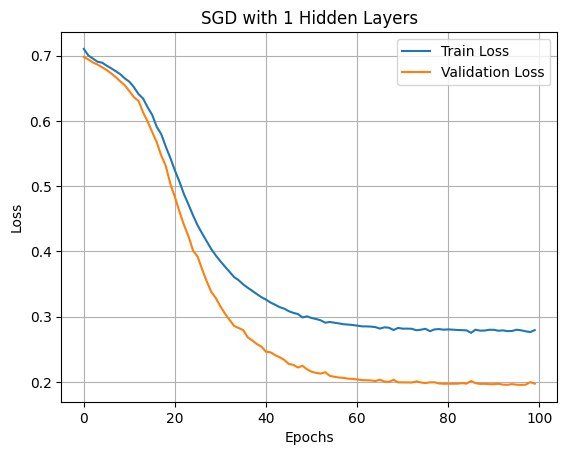

In [14]:
model_history_sgd_with_1_hidden_layer = model_sgd_with_1_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, verbose=verbosity_level)
plot_loss(model_history_sgd_with_1_hidden_layer, 'SGD with 1 Hidden Layers')

Yukarıdaki grafikten ve model çıktılarından anlaşıldığı üzere model training set üzerinde %87 doğruluk oranına ulaşırken, validation set üzerinde %93 başarıya ulaşmıştır.
* Bu durumu loss değerinin validation için daha fazla 0 a yaklaştırılmasından da anlayabiliriz.
* Bu durum modelin overfitting yapmadığını gösterir.
* Modelin 60 epoch eğitilmesi sonucu oluşan loss değeri ile 100 epoch eğitilmesi sonucu oluşan epoch değerleri neredeyse bir birine yakındır.
* Bu nedenle modelin 60 epoch eğitilmesi yeterli olacaktır yorumu yapılabilir.

2 hidden layer için model özeti aşağıdaki gibidir.

In [15]:
hidden_layer_count = 2
model_sgd_with_2_hidden_layer = create_model(hidden_layer_count)
model_sgd_with_2_hidden_layer.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

Çift gizli katmanlı model sonuçlarını çizdirmek gerekirse aşağıdaki gibidir;

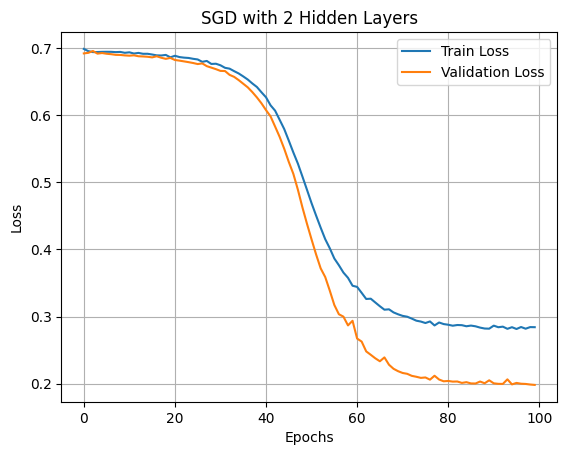

In [16]:
model_history_sgd_with_2_hidden_layer = model_sgd_with_2_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, verbose=verbosity_level)
plot_loss(model_history_sgd_with_2_hidden_layer, 'SGD with 2 Hidden Layers')

* Modelin yaklaşık 80 epoch eğitilmesi sonucu oluşan loss değeri ile 100 epoch eğitilmesi sonucu oluşan epoch değerleri neredeyse birbirine yakındır.
* Bu nedenle modelin 80 epoch eğitilmesi yeterli olacaktır yorumu yapılabilir.

Üç hidden layer için model özeti aşağıdaki gibidir.

In [17]:
hidden_layer_count = 3
model_sgd_with_3_hidden_layer = create_model(hidden_layer_count)
model_sgd_with_3_hidden_layer.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371 (1.45 KB)

 Trainable params: 371 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

Üç gizli katmanlı model sonuçlarını çizdirmek gerekirse aşağıdaki gibidir;

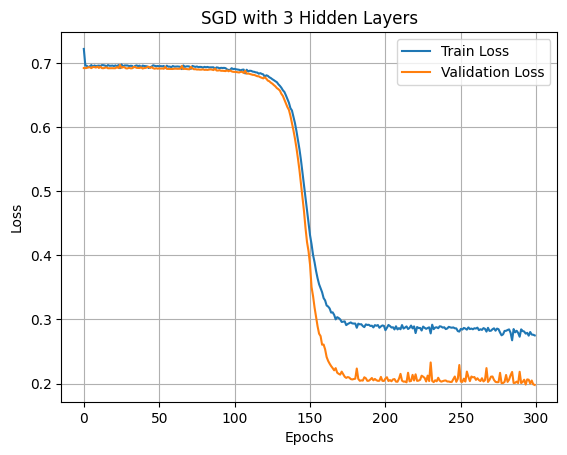

In [18]:
model_history_sgd_with_3_hidden_layer = model_sgd_with_3_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=300, batch_size=1, verbose=verbosity_level)
plot_loss(model_history_sgd_with_3_hidden_layer, 'SGD with 3 Hidden Layers')

Yukarıdaki grafikten ve model çıktılarından anlaşıldığı üzere model training ve validation set üzerinde 100 epoch için hiç fit (no fitting) edememiştir. Modelin hiç öğrenemediğini gösterir. Epoch sayısı 300 e çıkarılarak denendiğinde öğrenmenin gerçekleştiği görülmüştür.
* Genel olarak 1, 2, 3 katmanlı SGD sonuçlarını karşılaştırmak gerekirse en başarılı sonuç tek gizli katmanlı modelde elde edilmiştir.
* 1 ve 2 gizli katmanlı sonuçlar fit ettiğini göstermesine rağmen,
  * 1 gizli katmanlı modelin 60 epoch eğitilmesi yeterli olurken, 2 gizli katmanlı modelin 80 epoch eğitilmesi gerekmektedir.
  * Bu da 1 gizli katmanlı modelin daha hızlı öğrenme yeteneğine sahip olduğunu gösterir.
  * Bu nedenle en başarılı model 1 gizli katmanlı modeldir.

### 2. - c. - ii. Batch Gradient Descent (BGD)

ii. Batch Gradient Descent için x ekseni epoch sayısını y ekseni gösteren bir grafik üzerinde eğitim ve doğrulama örnekleri için değişimi gösteriniz.

In [19]:
hidden_layer_count = 1
model_bgd_with_1_hidden_layer = create_model(hidden_layer_count)
model_bgd_with_1_hidden_layer.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

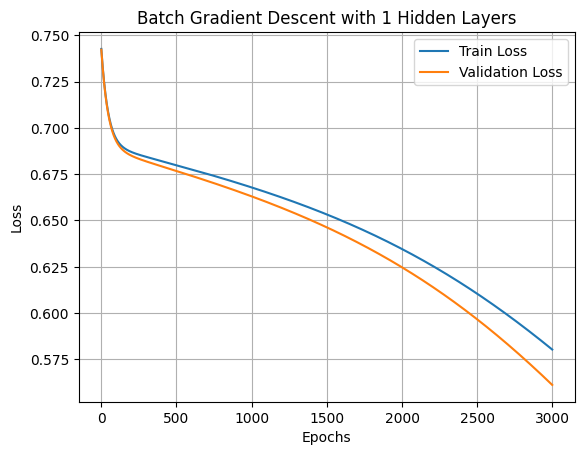

In [20]:
model_history_bgd_with_1_hidden_layer = model_bgd_with_1_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3000, batch_size=len(X_train), verbose=verbosity_level)
plot_loss(model_history_bgd_with_1_hidden_layer, 'Batch Gradient Descent with 1 Hidden Layers')

Batch Gradient Descent için oluşturulan model 3000 epoch eğitildiğinde tam olarak modelin fit edemediği görülmüştür.

In [21]:
hidden_layer_count = 2
model_bgd_with_2_hidden_layer = create_model(hidden_layer_count)
model_bgd_with_2_hidden_layer.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

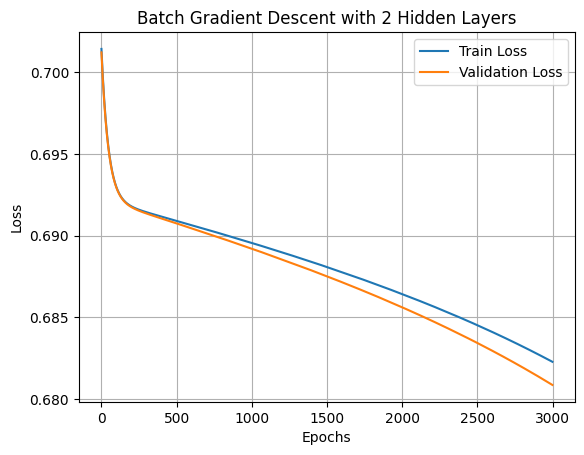

In [22]:
model_history_bgd_with_2_hidden_layer = model_bgd_with_2_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3000, batch_size=len(X_train), verbose=verbosity_level)
plot_loss(model_history_bgd_with_2_hidden_layer, f'Batch Gradient Descent with 2 Hidden Layers')

Yine 2 katmanlı için model tam olarak fit edememiştir. Yüksek epoch larda fit edebilir tam olarak öğrenme tamamlanamadı.

In [23]:
hidden_layer_count = 3
model_bgd_with_3_hidden_layer = create_model(hidden_layer_count)
model_bgd_with_3_hidden_layer.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371 (1.45 KB)

 Trainable params: 371 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

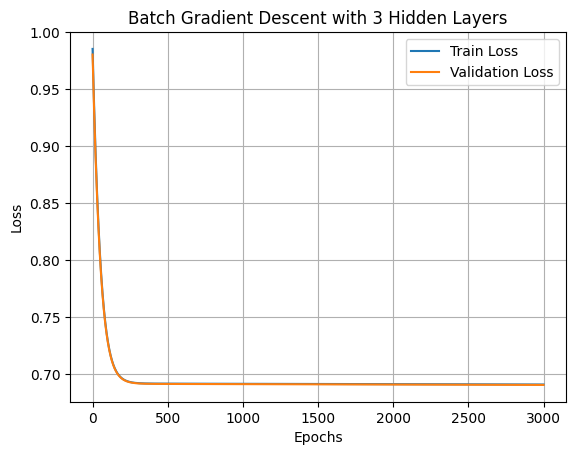

In [24]:
model_history_bgd_with_3_hidden_layer = model_bgd_with_3_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3000, batch_size=len(X_train), verbose=verbosity_level)
plot_loss(model_history_bgd_with_3_hidden_layer, f'Batch Gradient Descent with 3 Hidden Layers')

3 katmanı Batch Gradient Descent için modelin 250 ile 500 arasında bir yerde fit ettiği görülmüştür.
* Fakat loss değeri 0 a yaklaşmamıştır. Bu nedenle SGD kadar başarılı olamamıştır diyebiliriz.

### 2. - c. - iii. Mini Batch Gradient Descent (MBGD)

iii. Seçeceğiniz bir mini batch değeri için Mini Batch Gradient Descent ile x ekseni epoch sayısını y ekseni gösteren bir grafik üzerinde eğitim ve doğrulama örnekleri için değişimi gösteriniz.

In [25]:
hidden_layer_count = 1
model_mbgd_with_1_hidden_layer = create_model(hidden_layer_count)
model_mbgd_with_1_hidden_layer.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

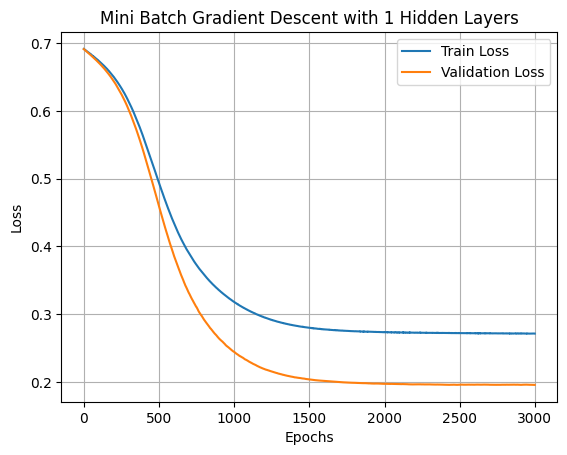

In [26]:
mini_batch_size = 32

model_history_mbgd_with_1_hidden_layer = model_mbgd_with_1_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3000, batch_size=mini_batch_size, verbose=verbosity_level)
plot_loss(model_history_mbgd_with_1_hidden_layer, 'Mini Batch Gradient Descent with 1 Hidden Layers')

32 batch size için 1 gizli katmanlı modelin 1500 epoch civarında fit ettiği görülmüştür.

In [27]:
hidden_layer_count = 2
model_mbgd_with_2_hidden_layer = create_model(hidden_layer_count)
model_mbgd_with_2_hidden_layer.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

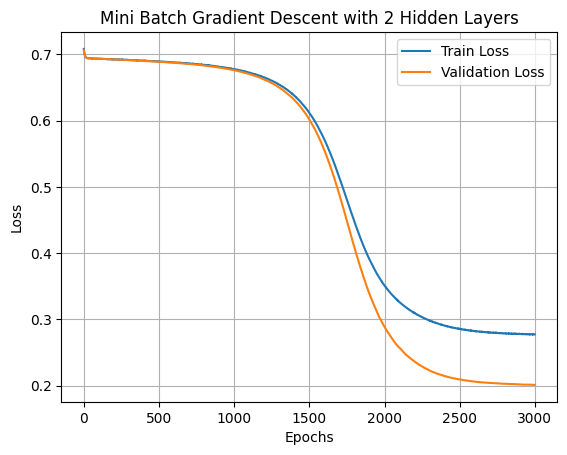

In [28]:
model_history_mbgd_with_2_hidden_layer = model_mbgd_with_2_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3000, batch_size=mini_batch_size, verbose=verbosity_level)
plot_loss(model_history_mbgd_with_2_hidden_layer, 'Mini Batch Gradient Descent with 2 Hidden Layers')

32 batch size için 2 gizli katmanlı modelin 3000 epoch civarında fit ettiği görülmüştür.
* Bu bize hidden layer sayısının arttıkça daha fazla epoch eğitilmesi gerektiğini gösterir.
* Modelin performansının gizli katman sayısı arttıkça azaldığını söyleyebiliriz.

In [29]:
hidden_layer_count = 3
model_mbgd_with_3_hidden_layer = create_model(hidden_layer_count)
model_mbgd_with_3_hidden_layer.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371 (1.45 KB)

 Trainable params: 371 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

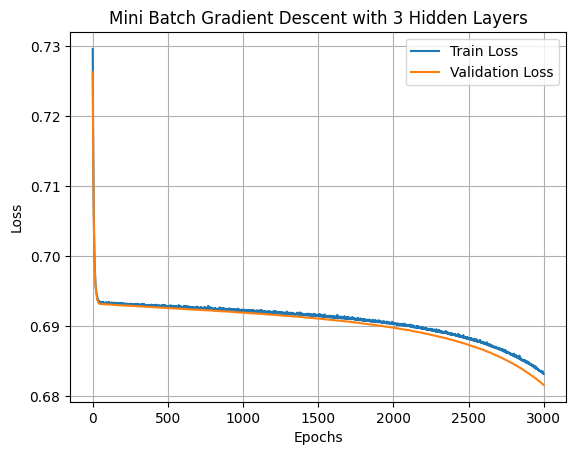

In [30]:
model_history_mbgd_with_3_hidden_layer = model_mbgd_with_3_hidden_layer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3000, batch_size=mini_batch_size, verbose=verbosity_level)
plot_loss(model_history_mbgd_with_3_hidden_layer, 'Mini Batch Gradient Descent with 3 Hidden Layers')

32 batch size için 3 gizli katmanlı modelin 3000 epoch sonunda fit edemediği görülmektedir.

### 2. - c. - iv. Karar Sınırlarının Çizdirilmesi (Decision Boundaries)

(i), (ii) ve (iii) durumları için öğrenme tamamlandığında ağınızın son halinin karar sınırlarını çizdiriniz.

In [ ]:
import numpy as np

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.title(title)
    plt.show()

SGD için karar sınırlarını çizdirelim. En başarılı model 1 gizli katmanlı model olduğu için onun karar sınırlarını çizdirelim.

6382/6382 ━━━━━━━━━━━━━━━━━━━━ 1s 182us/step


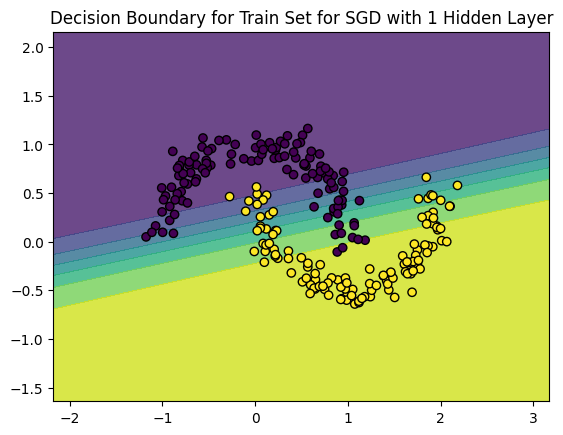

6018/6018 ━━━━━━━━━━━━━━━━━━━━ 1s 183us/step


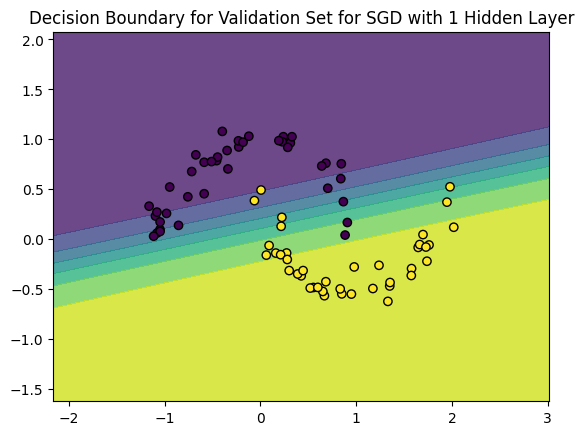

6164/6164 ━━━━━━━━━━━━━━━━━━━━ 1s 182us/step


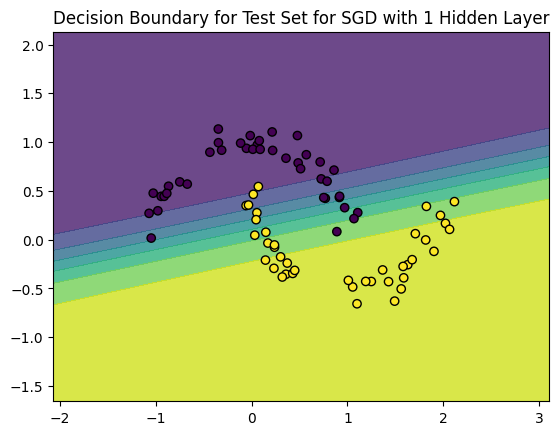

In [ ]:
plot_decision_boundary(model_sgd_with_1_hidden_layer, X_train, y_train, 'Decision Boundary for Train Set for SGD with 1 Hidden Layer')
plot_decision_boundary(model_sgd_with_1_hidden_layer, X_val, y_val, 'Decision Boundary for Validation Set for SGD with 1 Hidden Layer')
plot_decision_boundary(model_sgd_with_1_hidden_layer, X_test, y_test, 'Decision Boundary for Test Set for SGD with 1 Hidden Layer')

Batch Gradient Descent için karar sınırlarını çizdirelim. En başarılı 1 gizli katmanlı model olduğu için onun karar sınırlarını çizdirelim.

6382/6382 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step


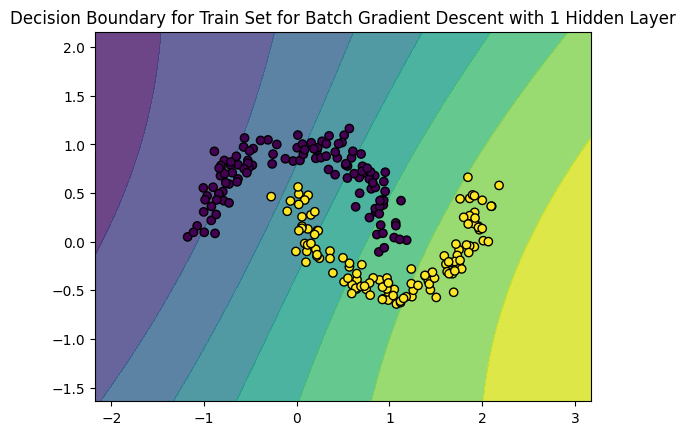

6018/6018 ━━━━━━━━━━━━━━━━━━━━ 1s 181us/step


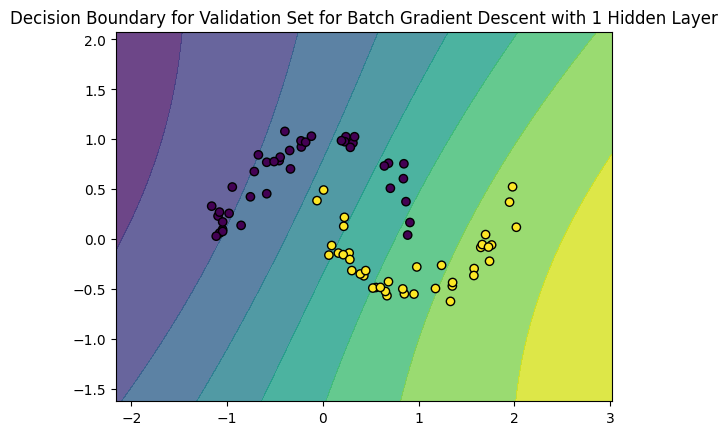

6164/6164 ━━━━━━━━━━━━━━━━━━━━ 1s 181us/step


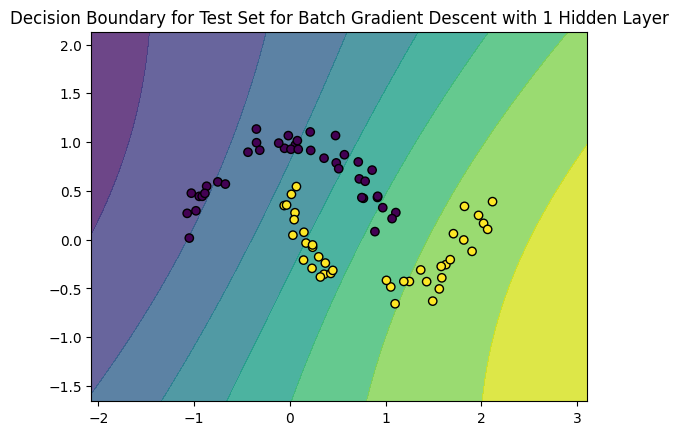

In [33]:
plot_decision_boundary(model_bgd_with_1_hidden_layer, X_train, y_train, 'Decision Boundary for Train Set for Batch Gradient Descent with 1 Hidden Layer')
plot_decision_boundary(model_bgd_with_1_hidden_layer, X_val, y_val, 'Decision Boundary for Validation Set for Batch Gradient Descent with 1 Hidden Layer')
plot_decision_boundary(model_bgd_with_1_hidden_layer, X_test, y_test, 'Decision Boundary for Test Set for Batch Gradient Descent with 1 Hidden Layer')

Mini Batch Gradient Descent için karar sınırlarını çizdirelim. En başarılı 1 gizli katmanlı model olduğu için onun karar sınırlarını çizdirelim.

6382/6382 ━━━━━━━━━━━━━━━━━━━━ 1s 188us/step


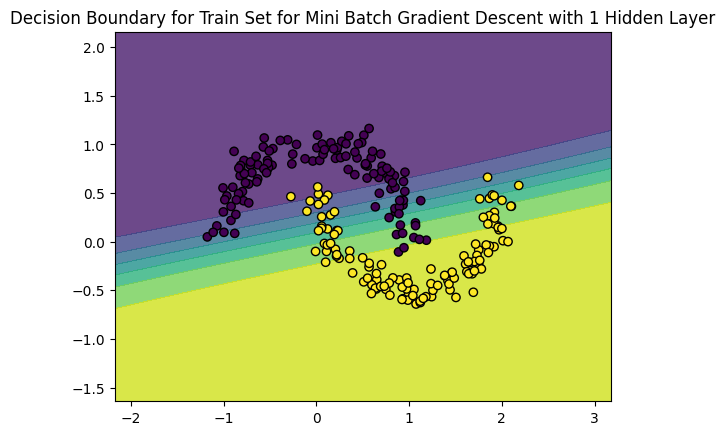

6018/6018 ━━━━━━━━━━━━━━━━━━━━ 1s 183us/step


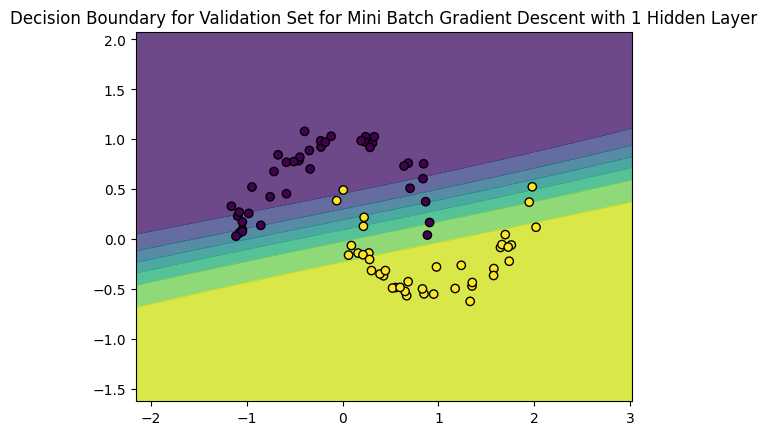

6164/6164 ━━━━━━━━━━━━━━━━━━━━ 1s 183us/step


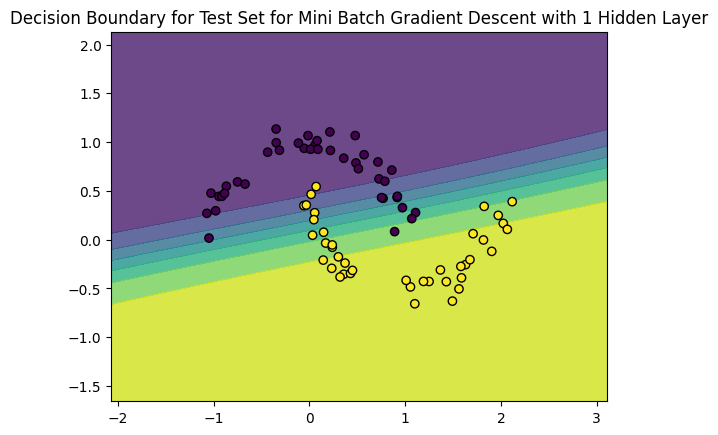

In [34]:
plot_decision_boundary(model_mbgd_with_1_hidden_layer, X_train, y_train, 'Decision Boundary for Train Set for Mini Batch Gradient Descent with 1 Hidden Layer')
plot_decision_boundary(model_mbgd_with_1_hidden_layer, X_val, y_val, 'Decision Boundary for Validation Set for Mini Batch Gradient Descent with 1 Hidden Layer')
plot_decision_boundary(model_mbgd_with_1_hidden_layer, X_test, y_test, 'Decision Boundary for Test Set for Mini Batch Gradient Descent with 1 Hidden Layer')

## 2. - d. En Başarılı Durumun Değerlendirilmesi

```text
(c) şıkkındaki en başarılı durum için eğitim örnekleri için çizdirdiğiniz grafik üzerinde doğrulama örnekleri için de grafiği çizdirerek eğitim ve doğrulama örneklerinin birbirine göre durumunu değerlendirerek aşırı öğrenme olup olmadığını değerlendiriniz. 

Aşırı öğrenme varsa iyileştirme yapınız. Eğer iyileştirme ihtiyacı varsa nasıl yaptığınızı raporunuzda anlatınız ve yeni bir grafik üzerinde son durumu gösteriniz.
```

Modellerin başarıları aşağıdaki gibidir:

* Aşağıda görüldüğü gibi SDG için en başarılı model validation set üzerinde %95 başarıya ulaşan 1 gizli katmanlı modeldir.
```text
SGD with 1 Hidden Layers: Epoch 100/100
240/240 - 0s - 338us/step - accuracy: 0.8875 - loss: 0.2770 - val_accuracy: 0.9500 - val_loss: 0.1989

SGD with 2 Hidden Layers: Epoch 100/100
240/240 - 0s - 271us/step - accuracy: 0.8792 - loss: 0.2819 - val_accuracy: 0.9375 - val_loss: 0.2003

SGD with 3 Hidden Layers: Epoch 300/300
240/240 - 0s - 272us/step - accuracy: 0.8917 - loss: 0.2817 - val_accuracy: 0.9250 - val_loss: 0.2130
```

* Aşağıda görüldüğü gibi Batch Gradient Descent için en başarılı model validation set üzerinde %83 başarıya ulaşan 1 gizli katmanlı modeldir.

```text
Batch Gradient Descent with 1 Hidden Layers: Epoch 3000/3000
1/1 - 0s - 12ms/step - accuracy: 0.7625 - loss: 0.5844 - val_accuracy: 0.8375 - val_loss: 0.5677

Batch Gradient Descent with 2 Hidden Layers: Epoch 3000/3000
1/1 - 0s - 13ms/step - accuracy: 0.6583 - loss: 0.6907 - val_accuracy: 0.6500 - val_loss: 0.6903

Batch Gradient Descent with 3 Hidden Layers: Epoch 3000/3000
1/1 - 0s - 12ms/step - accuracy: 0.5875 - loss: 0.6928 - val_accuracy: 0.6250 - val_loss: 0.6928
```

* Aşağıda görüldüğü gibi Mini Batch Gradient Descent için en başarılı model validation set üzerinde %93 başarıya ulaşan 1 gizli katmanlı modeldir.
```text
Mini Batch Gradient Descent with 1 Hidden Layers: Epoch 3000/3000
8/8 - 0s - 2ms/step - accuracy: 0.8958 - loss: 0.2741 - val_accuracy: 0.9375 - val_loss: 0.1989

Mini Batch Gradient Descent with 2 Hidden Layers: Epoch 3000/3000
8/8 - 0s - 2ms/step - accuracy: 0.8208 - loss: 0.3744 - val_accuracy: 0.8875 - val_loss: 0.3142

Mini Batch Gradient Descent with 3 Hidden Layers: Epoch 3000/3000
8/8 - 0s - 2ms/step - accuracy: 0.7083 - loss: 0.6901 - val_accuracy: 0.8750 - val_loss: 0.6896
```

Yukarıdaki verilerden anlaşılacağı üzere tüm hepsi arasında en başarılı olan model SGD ile 1 gizli katmanlı modeldir.
* Bu model training set üzerinde %88 doğruluk oranına ulaşırken, validation set üzerinde %95 başarıya ulaşmıştır.
* Bu durum modelin overfitting yapmadığını gösterir. Ayrıca aşağıdaki loss grafiğinden de bu durum anlaşılabilir.
* Aşırı öğrenme olmadığı için model üzerinde early stopping veya dropout gibi düzenlemeler yapmaya gerek yoktur.

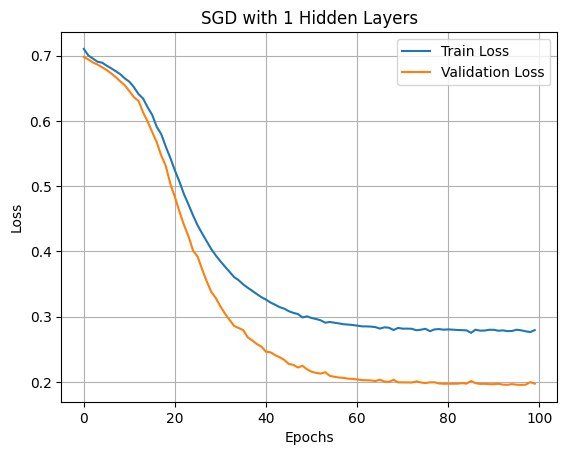

In [35]:
plot_loss(model_history_sgd_with_1_hidden_layer, 'SGD with 1 Hidden Layers')

## 2. - e. Test Seti İle Değerlendirme (Confusion Matrix, Accuracy, Precision, Recall, F1-Score)

Eğitim, doğrulama ve test örnekleri için confusion matrix’i veriniz.  Accuracy, precision, recall ve f-scrore hesabını yapınız.

Confusion matrix i oluşturmak için aşağıdaki fonksiyonu kullanabiliriz.


In [36]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Performance metriklerini hesaplamak için aşağıdaki fonksiyonu kullanabiliriz.

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Final performance evaluation of the model
def get_model_results(y_true, y_pred, data_type, optimizer_name):
    results = []

    accuracy = accuracy_score(y_true, y_pred)
    accuracy = f"{accuracy * 100:.2f}%"

    precision = precision_score(y_true, y_pred)
    precision = f"{precision:.3f}"

    recall = recall_score(y_true, y_pred)
    recall = f"{recall:.3f}"

    f1 = f1_score(y_true, y_pred)
    f1 = f"{f1:.3f}"

    results.append({'Model': optimizer_name, 'Data': f'{data_type}', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})

    return pd.DataFrame(results)

Train veri kümesi için confusion matrix i  ve performance metriklerini hesaplayalım.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
Confusion matrix, without normalization
[[105  15]
 [ 12 108]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,SGD with 1 Hidden Layer,Train,88.75%,0.878,0.900,0.889


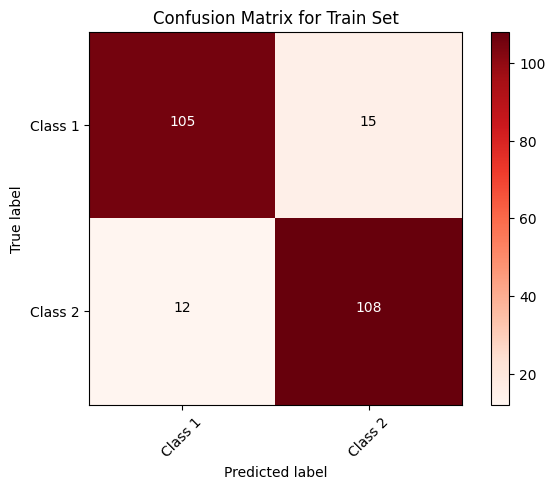

In [38]:
from sklearn.metrics import confusion_matrix

# Tahminler
y_train_pred = (model_sgd_with_1_hidden_layer.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Train Set')

# Performans Değerleri
train_results_df = get_model_results(y_train, y_train_pred, 'Train', 'SGD with 1 Hidden Layer')
all_results_df = pd.DataFrame()
all_results_df = pd.concat([all_results_df, train_results_df], ignore_index=True)

display(train_results_df)

Validation veri kümesi için confusion matrix i ve performance metriklerini hesaplayalım.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
Confusion matrix, without normalization
[[38  2]
 [ 2 38]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,SGD with 1 Hidden Layer,Validation,95.00%,0.950,0.950,0.950


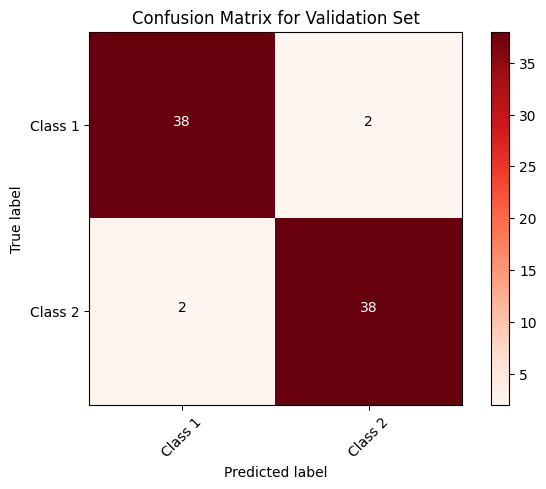

In [39]:
# Tahminler
y_val_pred = (model_sgd_with_1_hidden_layer.predict(X_val) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Validation Set')

# Performans Değerleri
val_results_df = get_model_results(y_val, y_val_pred, 'Validation', 'SGD with 1 Hidden Layer')
all_results_df = pd.concat([all_results_df, val_results_df], ignore_index=True)

display(val_results_df)

Test veri kümesi için confusion matrix i ve performance metriklerini hesaplayalım.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
Confusion matrix, without normalization
[[36  4]
 [ 6 34]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,SGD with 1 Hidden Layer,Test,87.50%,0.895,0.850,0.872


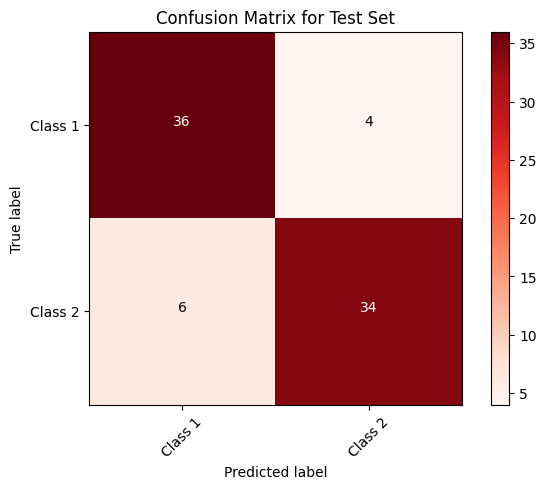

In [40]:
# Tahminler
y_test_pred = (model_sgd_with_1_hidden_layer.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Test Set')

# Performans Değerleri
test_results_df = get_model_results(y_test, y_test_pred, 'Test', 'SGD with 1 Hidden Layer')
all_results_df = pd.concat([all_results_df, test_results_df], ignore_index=True)

display(test_results_df)

Tüm veri kümesi için performance metrikleri aşağıdaki gibi çıkmıştır.

In [41]:
display(all_results_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score
0,SGD with 1 Hidden Layer,Train,88.75%,0.878,0.900,0.889
1,SGD with 1 Hidden Layer,Validation,95.00%,0.950,0.950,0.950
2,SGD with 1 Hidden Layer,Test,87.50%,0.895,0.850,0.872


# 3. Destek Vektör Makineleri / Support Vector Machines (SVM)

Destek Vektör Makinesi öğrenme modeli için aşağıdaki işlemleri yapınız.


## 3. - a. Kernel Seçimi - Linear, Polynomial, Gaussian RBF

Kernel olarak sırasıyla lineer, polinomsal ve Gaussian RBF kullanarak aşağıdaki işlemleri
yapınız:

### 3. - a. - i. Kernel Parametreleri Optimizasyonu

Farklı parametre değerleri ile denemeler yaparak her kernel için en başarılı sonucu veren parametreleri belirleyiniz.

Linear kernel için en başarılı sonuçları bulalım.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Lineer kernel için parametre arama
param_grid_linear = {'C': [0.1, 1, 10, 100]}
grid_search_linear = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=5)
grid_search_linear.fit(X_train, y_train)

# En iyi parametreler
best_params_linear = grid_search_linear.best_params_
logger.info(f"Best parameters for linear kernel: {best_params_linear}")

[INFO] [2024-12-15T17:28:27.476Z] Best parameters for linear kernel: {'C': 10}


Polinomsal kernel için en başarılı sonuçları bulalım.

In [43]:
# Polinomsal kernel için parametre arama
param_grid_poly = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5]}
grid_search_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=5)
grid_search_poly.fit(X_train, y_train)

# En iyi parametreler
best_params_poly = grid_search_poly.best_params_
logger.info(f"Best parameters for polynomial kernel: {best_params_poly}")

[INFO] [2024-12-15T17:28:27.631Z] Best parameters for polynomial kernel: {'C': 100, 'degree': 3}


Gaussian RBF kernel için en başarılı sonuçları bulalım.

In [44]:
# Gaussian RBF kernel için parametre arama
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}
grid_search_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=5)
grid_search_rbf.fit(X_train, y_train)

# En iyi parametreler
best_params_rbf = grid_search_rbf.best_params_
logger.info(f"Best parameters for RBF kernel: {best_params_rbf}")

[INFO] [2024-12-15T17:28:27.692Z] Best parameters for RBF kernel: {'C': 0.1, 'gamma': 10}


### 3. - a. - ii. Karar Sınırlarının Çizdirilmesi (Decision Boundaries)

En başarılı durum için SVM modelinin karar sınırlarını çizdiriniz.

En iyi linear için karar sınırını çizdirelim.

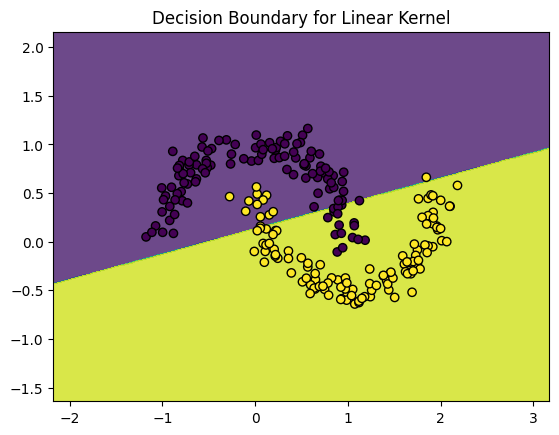

In [45]:
# En iyi lineer kernel modeli
best_linear_model = SVC(kernel='linear', **best_params_linear)
best_linear_model.fit(X_train, y_train)
plot_decision_boundary(best_linear_model, X_train, y_train, 'Decision Boundary for Linear Kernel')

En iyi polinomsal için karar sınırını çizdirelim.

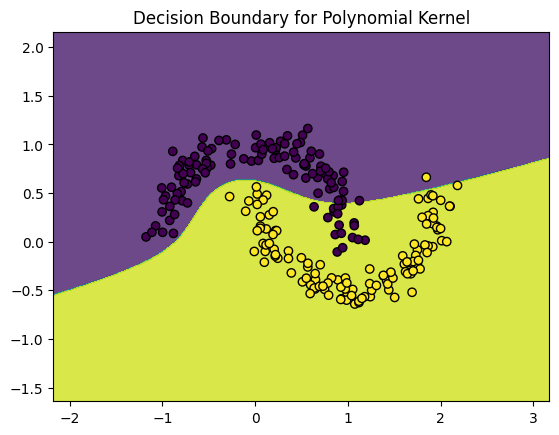

In [46]:
# En iyi polinomsal kernel modeli
best_poly_model = SVC(kernel='poly', **best_params_poly)
best_poly_model.fit(X_train, y_train)
plot_decision_boundary(best_poly_model, X_train, y_train, 'Decision Boundary for Polynomial Kernel')


En iyi Gaussian RBF için karar sınırını çizdirelim.

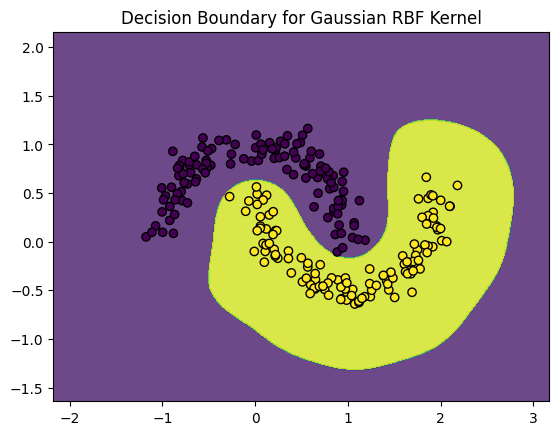

In [47]:
# En iyi RBF kernel modeli
best_rbf_model = SVC(kernel='rbf', **best_params_rbf)
best_rbf_model.fit(X_train, y_train)
plot_decision_boundary(best_rbf_model, X_train, y_train, 'Decision Boundary for Gaussian RBF Kernel')

### 3. - a. - iii. Test Seti İle Değerlendirme (Confusion Matrix, Accuracy, Precision, Recall, F1-Score)

En başarılı durum için eğitim, doğrulama ve test örnekleri için confusion matrix’i veriniz.  
Accuracy, precision, recall ve f-scrore hesabını yapınız.

Linaer kernel için confusion matrix i ve performance metriklerini hesaplayalım.

Confusion matrix, without normalization
[[103  17]
 [ 13 107]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Train,87.50%,0.863,0.892,0.877


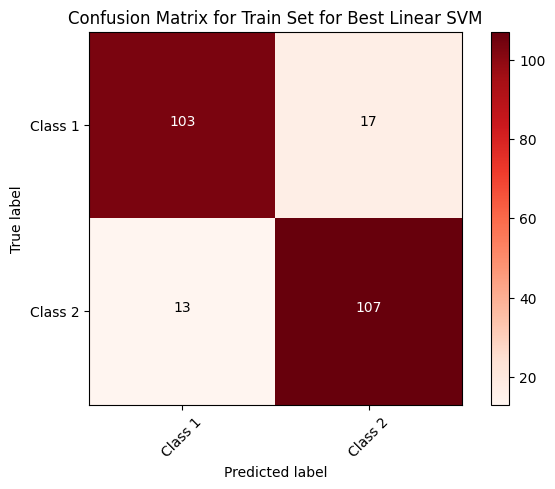

In [48]:
# Tahminler
best_linear_model_y_train_pred = (best_linear_model.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, best_linear_model_y_train_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Train Set for Best Linear SVM')

# Performans Değerleri
best_linear_train_results_df = get_model_results(y_train, best_linear_model_y_train_pred, 'Train', 'Best Linear SVM')
all_svm_results_df = pd.DataFrame()
all_svm_results_df = pd.concat([all_svm_results_df, best_linear_train_results_df], ignore_index=True)

display(best_linear_train_results_df)

Confusion matrix, without normalization
[[38  2]
 [ 3 37]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Validation,93.75%,0.949,0.925,0.937


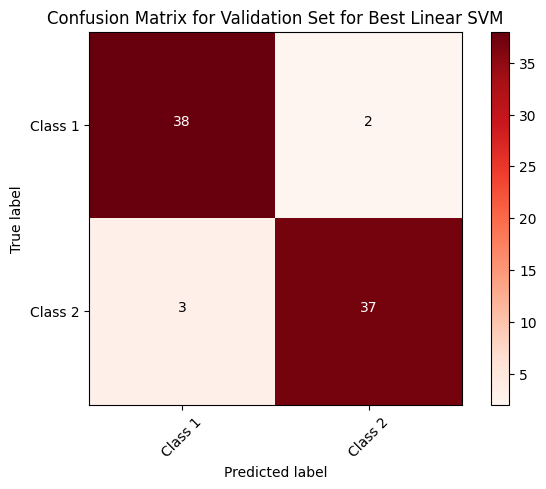

In [49]:
# Tahminler
best_lienar_model_y_val_pred = (best_linear_model.predict(X_val) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, best_lienar_model_y_val_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Validation Set for Best Linear SVM')

# Performans Değerleri
best_linear_val_results_df = get_model_results(y_val, best_lienar_model_y_val_pred, 'Validation', 'Best Linear SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_linear_val_results_df], ignore_index=True)

display(best_linear_val_results_df)

Confusion matrix, without normalization
[[36  4]
 [ 6 34]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Test,87.50%,0.895,0.850,0.872


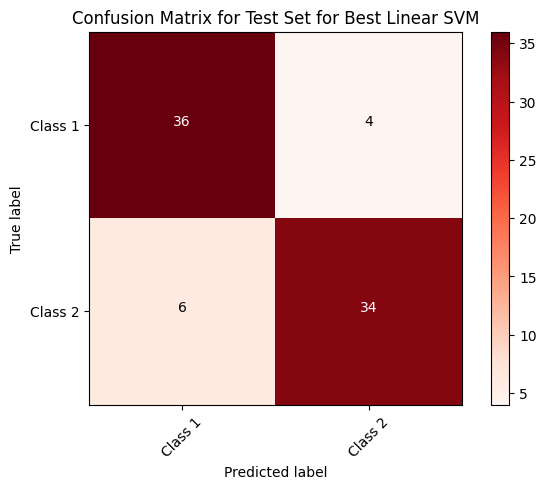

In [50]:
# Tahminler
best_linear_model_y_test_pred = (best_linear_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, best_linear_model_y_test_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Test Set for Best Linear SVM')

# Performans Değerleri
best_linear_test_results_df = get_model_results(y_test, best_linear_model_y_test_pred, 'Test', 'Best Linear SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_linear_test_results_df], ignore_index=True)

display(best_linear_test_results_df)

En iyi polinomsal kernel için confusion matrix i ve performance metriklerini hesaplayalım.

Confusion matrix, without normalization
[[103  17]
 [  1 119]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Polynomial SVM,Train,92.50%,0.875,0.992,0.930


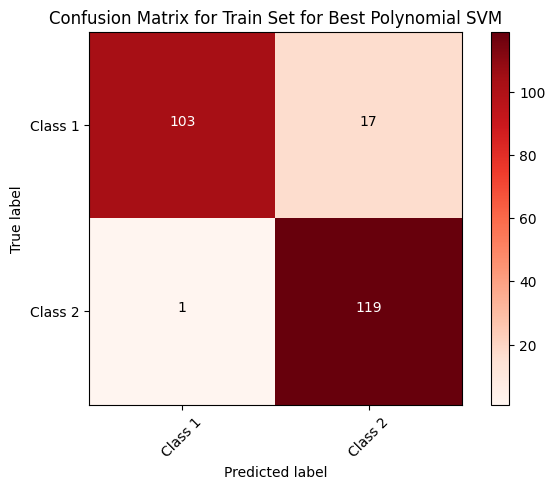

In [51]:
# Tahminler
best_poly_model_y_train_pred = (best_poly_model.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, best_poly_model_y_train_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Train Set for Best Polynomial SVM')

# Performans Değerleri
best_poly_train_results_df = get_model_results(y_train, best_poly_model_y_train_pred, 'Train', 'Best Polynomial SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_poly_train_results_df], ignore_index=True)

display(best_poly_train_results_df)

Confusion matrix, without normalization
[[37  3]
 [ 0 40]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Polynomial SVM,Validation,96.25%,0.930,1.000,0.964


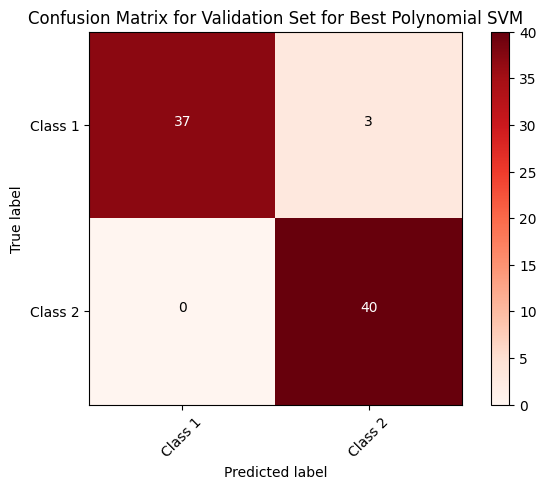

In [52]:
# Tahminler
best_poly_model_y_val_pred = (best_poly_model.predict(X_val) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, best_poly_model_y_val_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Validation Set for Best Polynomial SVM')

# Performans Değerleri
best_poly_val_results_df = get_model_results(y_val, best_poly_model_y_val_pred, 'Validation', 'Best Polynomial SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_poly_val_results_df], ignore_index=True)

display(best_poly_val_results_df)

Confusion matrix, without normalization
[[36  4]
 [ 0 40]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Polynomial SVM,Test,95.00%,0.909,1.000,0.952


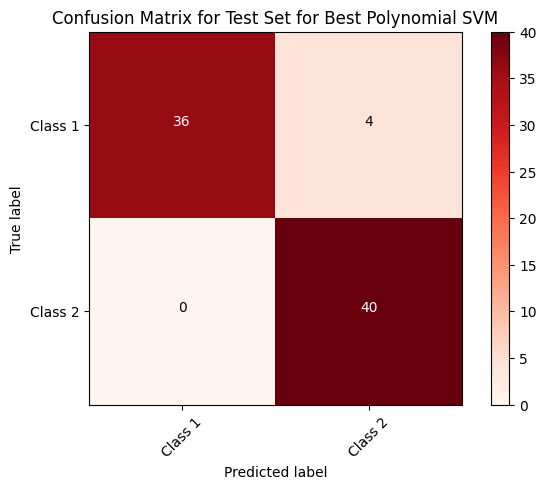

In [53]:
# Tahminler
best_poly_model_y_test_pred = (best_poly_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, best_poly_model_y_test_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Test Set for Best Polynomial SVM')

# Performans Değerleri
best_poly_test_results_df = get_model_results(y_test, best_poly_model_y_test_pred, 'Test', 'Best Polynomial SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_poly_test_results_df], ignore_index=True)

display(best_poly_test_results_df)

Gaussion RBF kernel için confusion matrix i ve performance metriklerini hesaplayalım.

Confusion matrix, without normalization
[[120   0]
 [  0 120]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best RBF SVM,Train,100.00%,1.000,1.000,1.000


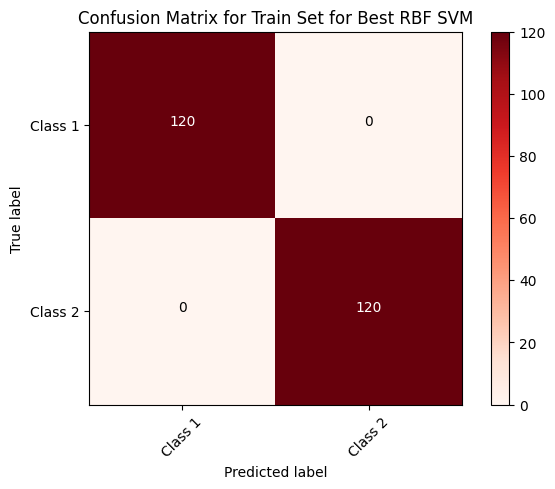

In [54]:
# Tahminler
best_rbf_model_y_train_pred = (best_rbf_model.predict(X_train) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_train, best_rbf_model_y_train_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Train Set for Best RBF SVM')

# Performans Değerleri
best_rbf_train_results_df = get_model_results(y_train, best_rbf_model_y_train_pred, 'Train', 'Best RBF SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_rbf_train_results_df], ignore_index=True)

display(best_rbf_train_results_df)

Confusion matrix, without normalization
[[40  0]
 [ 0 40]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best RBF SVM,Validation,100.00%,1.000,1.000,1.000


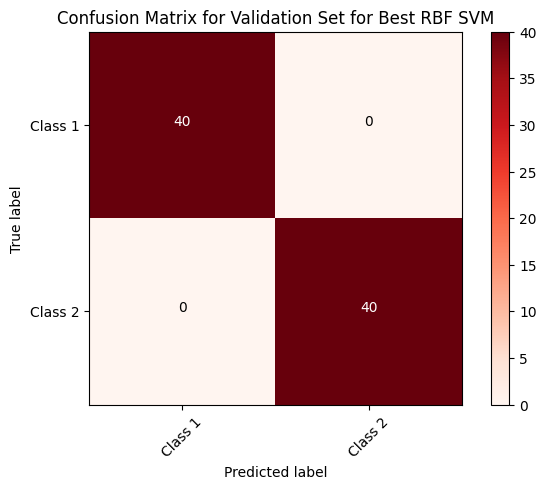

In [55]:
# Tahminler
best_rbf_model_y_val_pred = (best_rbf_model.predict(X_val) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, best_rbf_model_y_val_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Validation Set for Best RBF SVM')

# Performans Değerleri
best_rbf_val_results_df = get_model_results(y_val, best_rbf_model_y_val_pred, 'Validation', 'Best RBF SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_rbf_val_results_df], ignore_index=True)

display(best_rbf_val_results_df)


Confusion matrix, without normalization
[[40  0]
 [ 0 40]]


,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best RBF SVM,Test,100.00%,1.000,1.000,1.000


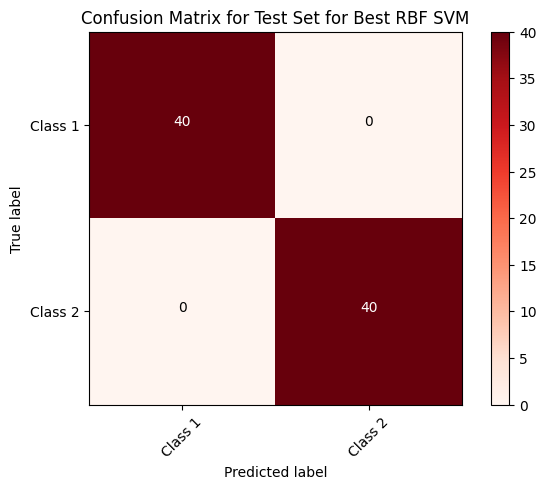

In [56]:
# Tahminler
best_rbf_model_y_test_pred = (best_rbf_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, best_rbf_model_y_test_pred)
plot_confusion_matrix(cm, classes=['Class 1', 'Class 2'], title='Confusion Matrix for Test Set for Best RBF SVM')

# Performans Değerleri
best_rbf_test_results_df = get_model_results(y_test, best_rbf_model_y_test_pred, 'Test', 'Best RBF SVM')
all_svm_results_df = pd.concat([all_svm_results_df, best_rbf_test_results_df], ignore_index=True)

display(best_rbf_test_results_df)

Tüm kerneller için performance metrikleri aşağıdaki gibi çıkmıştır.

In [57]:
display(all_svm_results_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score
0,Best Linear SVM,Train,87.50%,0.863,0.892,0.877
1,Best Linear SVM,Validation,93.75%,0.949,0.925,0.937
2,Best Linear SVM,Test,87.50%,0.895,0.850,0.872
3,Best Polynomial SVM,Train,92.50%,0.875,0.992,0.930
4,Best Polynomial SVM,Validation,96.25%,0.930,1.000,0.964
5,Best Polynomial SVM,Test,95.00%,0.909,1.000,0.952
6,Best RBF SVM,Train,100.00%,1.000,1.000,1.000
7,Best RBF SVM,Validation,100.00%,1.000,1.000,1.000
8,Best RBF SVM,Test,100.00%,1.000,1.000,1.000


Yukarıdaki tablodan anlaşılacağı üzere en başarılı kernel bu dataset için Gaussian RBF kerneldir.

# 4. Sonuçların Karşılaştırılması

(2) ve (3)’de elde ettiğiniz sonuçlara göre hangi model en başarılı oldu? Elde ettiğiniz sonuçları yorumlayınız.

Yukarıdaki sonuçlar incelendiğinde en başarılı Gaussian RBF kernel ile elde edilen SVM modeli hem diğer SVM modellerinden hem de ANN modellerinden daha başarılıdır.
* Bu problem için hiç görmediği test veri setinde bile %100 başarıya ulaşmıştır.
* Bu sonuçlar incelendiğinde bu problem için en başarılı modelin Gaussian RBF kernel ile elde edilen SVM modeli olduğu söylenebilir.
* SGD, Batch Gradient Descent ve Mini Batch Gradient Descent ile elde edilen ANN modelleri incelendiğinde bunlar arasından en başarılı model SGD ile 1 gizli katmanlı modeldir.

# Referanslar
* [Scikit-learn 100:Datasets 3: Generated datasets](https://www.youtube.com/watch?v=NxvJ8kIkYUs) - Data generation ile ilgili bilgi almak için izlenen güzel bir video. Farklı shape ve özelliklerdeki veri setlerini nasıl oluşturabileceğimizi gösteriyor.